## Autoencoder
### 1. Discrete autoencoder using Prescribed Error Sensitivity (PES) plasticity rule

The system consists of 4 populations, given by the corresponding rate variables:
* $r_i^I$ - Input population
* $r_i^H$ - Hidden population
* $r_i^O$ - Output population
* $r_i^{\epsilon}$ - Error population

They are linked together by the following processes
<table>
    <tr>
        <td><p align="left"> Encoding </p></td>
        <td><p align="left"> $r_i^H = \sigma \biggl(\sum_i W^{\mathrm{ENC}}_{ij} r_j^I\biggr)$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> Decoding </p></td>
        <td><p align="left"> $r_i^O = \sum_i W^{\mathrm{DEC}}_{ij} r_j^H$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> Error Computation </p></td>
        <td><p align="left"> $r_i^{\epsilon} = r_i^I - r_i^O$ </p></td>
    </tr>
    <tr>
        <td><p align="left"> PES rule </p></td>
        <td><p align="left"> $\Delta W^{\mathrm{DEC}}_{ij} = \alpha r_i^{\epsilon} r_j^H$ </p></td>
    </tr>
</table>

**TODO**:
* Effects on memory capacity and denoising quality
  * Hidden units number
  * Encoding/Decoding sparsity
* Optimization of encoding
  * Find publications, propose strategies
* Rate model
  * Effects of lag
  * Find example where $\sigma(x)$ nonlinearity actually makes a difference (rate model fails, but semistatic succeeds)?
* Spiking model
  * Find publications, propose strategies
  * How to actually compute error given 2 spiking signals?
  * Why error correcting mechanism targets synapse, and not hidden layer neuron?
    * Is there a biological way PES could happen? Astrocytes?
    * IS there a purely neural way to do a PES analogue, that is, targeting hidden layer neuron with error signal

In [2]:
# Import libraries from outside folder
import sys
sys.path.append('../lib/')

import numpy as np
import matplotlib.pyplot as plt
import opencv_lib

In [3]:
# Lets write a spiking autoencoder with 1 hidden layer
def sigmoid(t, tau):
    return 1 / (1 + np.exp(-(t-0.5)/tau))

class AutoEncoder():
    def __init__(self, N_INP, N_HIDDEN, LEARNING_RATE, sparsity=0.1):
        self.LEARNING_RATE = LEARNING_RATE
        
        self.N_INP = N_INP
        self.N_HIDDEN = N_HIDDEN
        
        # Employ random sparse encoding matrix
        sparseEnc = np.random.uniform(0, 1, N_INP*N_HIDDEN).reshape((N_HIDDEN, N_INP)) < sparsity
        self.M_ENC = np.random.uniform(-1, 2, N_INP*N_HIDDEN).reshape((N_HIDDEN, N_INP)) / (N_INP * sparsity )
        self.M_ENC = np.multiply(self.M_ENC, sparseEnc)
        
        # Start with a random dense decoder matrix
        self.M_DEC = np.random.uniform(0, 2, N_INP*N_HIDDEN).reshape((N_INP, N_HIDDEN)) / N_HIDDEN
        
        # Init activity of hidden layer and output layer
        self.S_H = np.zeros(N_HIDDEN)
        self.V_O = np.zeros(N_INP)
        
    def update(self, V_I, withPES = False):
        V_H = self.M_ENC.dot(V_I)
        self.S_H = sigmoid(V_H, 0.1)
        self.V_O = self.M_DEC.dot(self.S_H)
        
        # PES learning rule
        if withPES:
            error = V_I - self.V_O
            self.M_DEC += self.LEARNING_RATE / self.N_HIDDEN * np.outer(error, self.S_H)

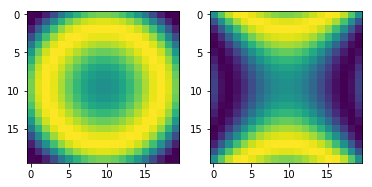

In [4]:
#Generate some random pictures
NPIX_X = 20
discr = np.linspace(0, 1, NPIX_X)
pic1 = np.array([[(1 + np.sin(10*((x-0.5)**2+(y-0.5)**2)))/2 for y in discr] for x in discr])
# pic1 = np.array([[(x+y)/2 for y in discr] for x in discr])
pic2 = np.array([[(1 + np.sin(10*((x-0.5)**2-(y-0.5)**2)))/2 for y in discr] for x in discr])

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(pic1)
ax[1].imshow(pic2)
plt.show()

In [14]:
%%time
# GENERATE NETWORK
AE1 = AutoEncoder(NPIX_X**2, NPIX_X**2, 0.5)

###############################
# Learning part
###############################

TIME_STEPS_SIM = 10000
PERIOD_INPUT_SWAP = 200
PERIOD_VIDEO_SAMPLE = 5
PADDING_LEN = 5
FRAME_PADDED_SHAPE = (NPIX_X, 3*NPIX_X + 2*PADDING_LEN)

inpFlat1 = np.ndarray.flatten(pic1)
inpFlat2 = np.ndarray.flatten(pic2)
framePadding = np.zeros((NPIX_X, PADDING_LEN))

# Threshold trace
with opencv_lib.cvWriter('rez/test2_semistatic_pes_learning.avi', FRAME_PADDED_SHAPE, codec='MJPG') as vid_inp:
    for iSim in range(TIME_STEPS_SIM):
        # Present different textures periodically
        if int(iSim / PERIOD_INPUT_SWAP) % 2 == 0:
            inp = inpFlat1 + np.random.uniform(-0.1, 0.1, NPIX_X**2)
        else:
            inp = inpFlat2 + np.random.uniform(-0.1, 0.1, NPIX_X**2)

        AE1.update(inp, withPES=True)

        # Write update to file sometimes
        if iSim % PERIOD_VIDEO_SAMPLE == 0:
            frameStack = np.hstack((
                255 * inp.reshape((NPIX_X, NPIX_X)),
                framePadding,
                255 * AE1.S_H.reshape((NPIX_X, NPIX_X)),
                framePadding,
                255 * AE1.V_O.reshape((NPIX_X, NPIX_X))
            ))
            
            #print("step", iSim)
            vid_inp.write(frameStack)


# ###############################
# # Testing part
# ###############################

TIME_STEPS_TEST = 1000
with opencv_lib.cvWriter('rez/test2_semistatic_pes_testing.avi', FRAME_PADDED_SHAPE, codec='MJPG') as vid_inp:
    for iTest in range(TIME_STEPS_TEST):
        if int(iTest / PERIOD_INPUT_SWAP) % 2 == 0:
            inp = inpFlat1 + np.random.uniform(-1, 1, NPIX_X**2)
        else:
            inp = inpFlat2 + np.random.uniform(-1, 1, NPIX_X**2)

        AE1.update(inp, withPES=False)

        if iTest % PERIOD_VIDEO_SAMPLE == 0:
            frameStack = np.hstack((
                255 * inp.reshape((NPIX_X, NPIX_X)),
                framePadding,
                255 * AE1.S_H.reshape((NPIX_X, NPIX_X)),
                framePadding,
                255 * AE1.V_O.reshape((NPIX_X, NPIX_X))
            ))
            
            #print("step", iSim)
            vid_inp.write(frameStack)

CPU times: user 11.2 s, sys: 21.6 s, total: 32.8 s
Wall time: 4.11 s
